# Case Study 4 - Augmentation

## The Task
Augment a small dataset using the concept of domain adaptation (or transfer learning). For this we will be using a RadialGAN as discussed in [this paper](https://arxiv.org/pdf/1802.06403.pdf).

### Imports
Lets import the required standard and 3rd party libraries and relevant Synthcity modules. We can also set the level of logging here. 

In [1]:
# stdlib
import warnings
from pathlib import Path

# 3rd Party
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score
import xgboost as xgb
import seaborn as sns
# from tqdm import tqdm

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.utils import serialization

warnings.filterwarnings("ignore")
# Set the level for the logging
# log.add(sink=sys.stderr, level="DEBUG")
log.remove()

/home/rob/miniconda3/envs/synth-lab/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The Scenario

Brazil is divided geopolitically into five macroregions: north, northeast, central-west, southeast, and south. For this case study, we will be acting as government officials in the Central-West Region of Brazil. Central-West Brazil is the smallest region in the country by population. It is also one of the larger and more rural regions. This means the number of COVID-19 patient records is significantly smaller compared to the larger regions.

<img src="../data/Brazil_COVID/Brazil_Labelled_Map.png" alt="Brazil Region Map" width="400"/>

COVID-19 hit different regions at different time. Cases peaked later in the Central-West than in the more densely-populated and well-connected regions. Giving us the problem of scarce data in terms of COVID-19 patients in the region, but the potential lifeline of having larger datasets from the other regions, which we can learn from in order to augment our dataset. We cannot simply train our model on the data from all regions, because there is significant co-variate shift between the different regions and so we will achieve a better classifier by training on solely Central-West data, even if it is synthetic. 

### Load the data
Lets set it up as a classification task with a death at time horizon column.  

In [12]:
time_horizon = 14
X = pd.read_csv(f"../data/Brazil_COVID/covid_normalised_numericalised.csv")

X.loc[(X["Days_hospital_to_outcome"] <= time_horizon) & (X["is_dead"] == 1), f"is_dead_at_time_horizon={time_horizon}"] = 1
X.loc[(X["Days_hospital_to_outcome"] > time_horizon), f"is_dead_at_time_horizon={time_horizon}"] = 0
X.loc[(X["is_dead"] == 0), f"is_dead_at_time_horizon={time_horizon}"] = 0
X[f"is_dead_at_time_horizon={time_horizon}"] = X[f"is_dead_at_time_horizon={time_horizon}"].astype(int)

X.drop(columns=["is_dead", "Days_hospital_to_outcome"], inplace=True) # drop survival columns as they are not needed for a classification problem

# Define the mappings from region index to region
region_mapper = {
    0: "Central-West",
    1: "North",
    2: "Northeast",
    3: "South",
    4: "Southeast",
}
our_region_index = 0
print(X["Region"].value_counts().rename(region_mapper))

X_our_region_only = X.loc[X["Region"] == our_region_index].copy()
X_other_regions = X.loc[X["Region"] != our_region_index].copy()

display(X_our_region_only)


Southeast       4929
Northeast        714
South            624
North            510
Central-West     105
Name: Region, dtype: int64


,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,is_dead_at_time_horizon=14
32,37,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
33,62,1,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
42,56,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
44,25,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,27,1,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6818,58,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6819,63,0,1,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6820,30,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6821,38,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# The problem

Lets train a model on just our data from the Central-West region.

In [13]:
y = X_our_region_only["is_dead_at_time_horizon=14"]
X_in = X_our_region_only.drop(columns=["is_dead_at_time_horizon=14"])

X_train, X_test, y_train, y_test = train_test_split(X_in, y, random_state=4)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Train model on whole dataset
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)
xgb_model.fit(X_train, y_train)

calculated_accuracy_score_train = accuracy_score(y_train, xgb_model.predict(X_train))
y_pred = xgb_model.predict(X_test)
calculated_accuracy_score_test = accuracy_score(y_test, y_pred)
print(f"Evaluating accuracy: train set: {calculated_accuracy_score_train} | test set: {calculated_accuracy_score_test}")


As you can see we are significantly overfitting due to the very small dataset.

v --- Get rid of this? It doesn't show what we want it to as well as it could... --- v
### Now lets test our assertion that we can't just use all the training data and apply it to our region
As you can see our accuracy does significantly improve, but we can do better! And there will be cases where there is a greater co-variate shift that impacts this accuracy to a much greater extent.

In [4]:
y = X["is_dead_at_time_horizon=14"]
X_in = X.drop(columns=["is_dead_at_time_horizon=14"])

X_train, _, y_train, _ = train_test_split(X_in, y, random_state=4)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

y = X_our_region_only["is_dead_at_time_horizon=14"]
X_in = X_our_region_only.drop(columns=["is_dead_at_time_horizon=14"])

_, X_test, _, y_test = train_test_split(X_in, y, random_state=4)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Train model on whole dataset
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)
xgb_model.fit(X_train, y_train)

calculated_accuracy_score_train = accuracy_score(y_train, xgb_model.predict(X_train))
y_pred = xgb_model.predict(X_test)
calculated_accuracy_score_test = accuracy_score(y_test, y_pred)
print(f"Evaluating accuracy: train set: {calculated_accuracy_score_train} | test set: {calculated_accuracy_score_test}")

Evaluating accuracy: train set: 0.8126332106180972 | test set: 0.9259259259259259


# The Solution

Load the super-set of data from all regions into the GerericDataLoader object.

In [ ]:
loader = GenericDataLoader(
    X, # X is the dataframe which is a superset of all region data
    target_column="is_dead_at_time_horizon=14", # The column containing the labels to predict
    sensitive_features=["Age", "Sex", "Ethnicity", "Region"], # The sensitive features in the dataset (Not needed here?)
    domain_column="Region", # This labels the domain that each record is from. Where it is `1` it is from our small dataset.
    random_state=42,
)


Lets use a RadialGan to augment the data. We need to load the plugin and then fit it to the dataloader object.

In [6]:
outdir = Path("saved_models")
prefix = "Augmentation"
model="radialgan"
n_iter = 10

print(model)

save_file = outdir / f"{prefix}.{model}_numericalised_{region_mapper[our_region_index]}_n_iter={n_iter}.bkp"
if Path(save_file).exists():
    syn_model = serialization.load_from_file(save_file)
else:
    syn_model = Plugins().get(model, n_iter=n_iter)
    syn_model.fit(loader)
    syn_model.generate(count=6882).dataframe()
    serialization.save_to_file(save_file, syn_model)


radialgan


Train a model on the generated data.

In [7]:
accuracies = []
generated_records = [
    1,2,3,4,5,6,7,8,9,10,
    20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,8000,10000,20000
]
for n_gen_records in generated_records:
    synth_data = syn_model.generate(n_gen_records, domains=[our_region_index])

    # Now we can augment our original dataset with our new synthetic data
    augmented_data = pd.concat([
        synth_data.dataframe(),
        X_our_region_only,
    ])

    augmented_y = augmented_data["is_dead_at_time_horizon=14"]
    augmented_X_in = augmented_data.drop(columns=["is_dead_at_time_horizon=14"])

    X_train, X_test, y_train, y_test = train_test_split(augmented_X_in, augmented_y, random_state=4)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    # Train model on whole dataset
    xgb_model = xgb.XGBClassifier(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8, 
        colsample_bytree=1, 
        gamma=1, 
        objective="binary:logistic",
        random_state=42,
    )
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    calculated_accuracy_score_train = accuracy_score(y_train, xgb_model.predict(X_train))
    calculated_accuracy_score_test = accuracy_score(y_test, y_pred)
    print(f"Evaluating accuracy: n_gen_records: {n_gen_records} train set: {calculated_accuracy_score_train}| test set: {calculated_accuracy_score_test}")
    accuracies.append(calculated_accuracy_score_test)

Evaluating accuracy: n_gen_records: 1 train set: 0.9113924050632911| test set: 0.7777777777777778
Evaluating accuracy: n_gen_records: 2 train set: 0.9375| test set: 0.7777777777777778
Evaluating accuracy: n_gen_records: 3 train set: 0.9382716049382716| test set: 0.7777777777777778
Evaluating accuracy: n_gen_records: 4 train set: 0.9382716049382716| test set: 0.7857142857142857
Evaluating accuracy: n_gen_records: 5 train set: 0.9512195121951219| test set: 0.7142857142857143
Evaluating accuracy: n_gen_records: 6 train set: 0.9036144578313253| test set: 0.8928571428571429
Evaluating accuracy: n_gen_records: 7 train set: 0.9285714285714286| test set: 0.8571428571428571
Evaluating accuracy: n_gen_records: 8 train set: 0.9404761904761905| test set: 0.7931034482758621
Evaluating accuracy: n_gen_records: 9 train set: 0.9411764705882353| test set: 0.7586206896551724
Evaluating accuracy: n_gen_records: 10 train set: 0.9186046511627907| test set: 0.7586206896551724
Evaluating accuracy: n_gen_reco

[(1, 0.7777777777777778), (2, 0.7777777777777778), (3, 0.7777777777777778), (4, 0.7857142857142857), (5, 0.7142857142857143), (6, 0.8928571428571429), (7, 0.8571428571428571), (8, 0.7931034482758621), (9, 0.7586206896551724), (10, 0.7586206896551724), (20, 0.78125), (30, 0.9117647058823529), (40, 0.7837837837837838), (50, 0.9230769230769231), (60, 0.8333333333333334), (70, 0.8863636363636364), (80, 0.8297872340425532), (90, 0.8163265306122449), (100, 0.7884615384615384), (200, 0.8831168831168831), (300, 0.8627450980392157), (400, 0.9448818897637795), (500, 0.9013157894736842), (600, 0.903954802259887), (700, 0.905940594059406), (800, 0.9030837004405287), (900, 0.9087301587301587), (1000, 0.9314079422382672), (2000, 0.9297912713472486), (3000, 0.9266409266409267), (4000, 0.9269717624148004), (5000, 0.9318715740015662), (8000, 0.9289590527873705), (10000, 0.9133359715077166), (20000, 0.9148597573105232)]


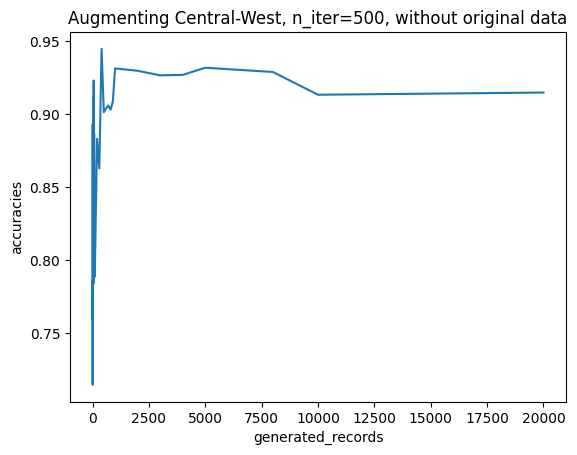

In [8]:
print(list(zip(generated_records, accuracies)))
d = {"generated_records": generated_records, "accuracies": accuracies}
accuracy_data= pd.DataFrame(d)
plot = sns.lineplot(y="accuracies", x="generated_records", data=accuracy_data).set(title=f"Augmenting {region_mapper[our_region_index]}, n_iter={500}, without {'original data'}")


### The Solution
Lets train the model on the augmented dataset and see what our performance is now.

In [10]:
n_gen_records = 5000

synth_data = syn_model.generate(n_gen_records, domains=[our_region_index])

# Now we can augment our original dataset with our new synthetic data
augmented_data = pd.concat([
    synth_data.dataframe(),
    X_our_region_only,
])

augmented_y = augmented_data["is_dead_at_time_horizon=14"]
augmented_X_in = augmented_data.drop(columns=["is_dead_at_time_horizon=14"])

X_train, X_test, y_train, y_test = train_test_split(augmented_X_in, augmented_y, random_state=4)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Train model on whole dataset
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
calculated_accuracy_score_train = accuracy_score(y_train, xgb_model.predict(X_train))
calculated_accuracy_score_test = accuracy_score(y_test, y_pred)
print(f"Evaluating accuracy: n_gen_records: {n_gen_records} train set: {calculated_accuracy_score_train}| test set: {calculated_accuracy_score_test}")
accuracies.append(calculated_accuracy_score_test)

Evaluating accuracy: n_gen_records: 5000 train set: 0.9341692789968652| test set: 0.9342208300704777


### The model no longer overfits on the training data and has an accuracy that is much higher.

```How to write up the difference between the whole dataset and the augmented dataset. Show the difference and explain that this may not always be the case, i.e. the populations of Brazil's different regions have little enough co-variate shift that it doesn't in fact cause a problem and this method is not strictly required here, but state there will be cases where it is? Or Brush it under the carpet...```